In [1]:
import pandas as pd
import numpy as np
import random
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from fancyimpute import KNN, NuclearNormMinimization

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# from imblearn.under_sampling import *
from imblearn.over_sampling import RandomOverSampler
# from fastFM import sgd

from xgboost import XGBClassifier, cv
from sklearn import svm
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.linear_model import ElasticNet, ElasticNetCV, LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

In [3]:
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold

In [4]:
df_adult = pd.read_excel('2017-06-28_ABDoseAdult_MW-v4.xlsx')
df       = pd.read_excel('2017-06-28_ABDoseAdult_MW-v4.xlsx')

df_adult['fu48_clinical_outcome'] = df_adult['fu48_clinical_outcome'].replace(3,2)
df_adult['fu48_clinical_outcome'] = df_adult['fu48_clinical_outcome'].replace(4,3)

df_neat = pd.read_csv('Adult_copy_sample.csv')
df_neat = df_neat.iloc[:,2:]
df_neat = df_neat.iloc[:,:191]

In [75]:
df_knn.groupby(['fu48_clinical_outcome','sex'])['age','bmi'].agg(['min','max','std','mean'])

age                                    bmi  \
                            min   max        std       mean        min   
fu48_clinical_outcome sex                                                
0.0                   0.0  19.1  90.4  17.708570  56.803947  16.540643   
                      1.0  17.2  85.2  15.708901  58.594231  13.840830   
1.0                   0.0  45.9  81.1  11.348735  67.960000  21.718066   
                      1.0  44.9  85.9  15.365600  75.116667  19.107515   

                                                           
                                 max       std       mean  
fu48_clinical_outcome sex                                  
0.0                   0.0  42.938301  5.939554  26.957653  
                      1.0  57.670127  8.399082  27.003118  
1.0                   0.0  43.944637  8.188398  30.760134  
                      1.0  28.444444  3.616162  23.407209

# Classify deceased/survived

In [5]:
df_fu_48 = df_adult.iloc[:,163:849]
df_fu_48 = df_fu_48.drop(['fu48_los'], axis=1)

df_fu_48 = pd.concat([df_neat,
                      df_adult['apache'],
                      df_fu_48],axis=1)

drop_dict = ['hospadmin_egfr',
             'baseline_egfr',
             'sd1_warfarin_yn',
             'sd1_egfr_60',
             'sd1_egfr',
             'sd2_warfarin_yn',
             'sd2_egfr_60',
             'sd2_egfr',
             'other_no_of_doses']

for column in drop_dict:
    df_fu_48 = df_fu_48.drop([column], axis=1)

In [6]:
for column in df_fu_48:
    if  df_fu_48[column].isnull().sum()/len(df_fu_48) > 0.5:
        df_fu_48 = df_fu_48.drop([column], axis=1)
        
df_object = df_fu_48.select_dtypes(include=['object'])
df_fu_48 = df_fu_48.select_dtypes(exclude=['object'])

In [7]:
def onehot_column(df, column_name):
    dummies = pd.get_dummies(df[column_name], prefix = column_name)
    return dummies

cat_dict = ['sd1_vent',
            'sd1_gcs_eyes',
            'sd1_gcs_voice',
            'sd1_gcs_move',
            'sd1_abg_source',
            'sd2_vent',
            'sd2_gcs_eyes',
            'sd2_gcs_voice',
            'sd2_gcs_move',
            'sd2_abg_source']

for item in cat_dict:
    df_fu_48 = pd.concat([df_fu_48, onehot_column(df_fu_48, item)],axis=1)
    df_fu_48 = df_fu_48.drop([item],axis=1)

In [8]:
df_fu_48['fu48_clinical_outcome'] = df_fu_48['fu48_clinical_outcome'].replace(1,0)
df_fu_48['fu48_clinical_outcome'] = df_fu_48['fu48_clinical_outcome'].replace(2,0)
df_fu_48['fu48_clinical_outcome'] = df_fu_48['fu48_clinical_outcome'].replace(3,1)

# Try NNM for imputation

In [9]:
df_nnm = KNN(k=5).complete(df_fu_48)

Imputing row 1/144 with 0 missing, elapsed time: 0.039
Imputing row 101/144 with 4 missing, elapsed time: 0.110


In [10]:
df_nnm = pd.DataFrame(df_nnm, columns=df_fu_48.columns, index=df_fu_48.index)

bmi = df_nnm['weight']/((df_nnm['height']/100)**2)
bmi = bmi.to_frame(name='bmi')
df_nnm = pd.concat([df_nnm,
                    bmi], axis=1)

np.any(np.isnan(df_nnm))

False

# Redo Normalisation

In [11]:
X = df_nnm.drop(['fu48_clinical_outcome'], axis=1)
Y = df_nnm['fu48_clinical_outcome']

# X_val = X_raw.values
# Y_val = Y_raw.values

# Normalisation
x = X.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X = pd.DataFrame(x_scaled, columns=X.columns)

# XGBoost

In [60]:
# XGBoost
NUM_TRIALS = 20

# n_estmators = [5, 10, 15, 20]
# max_depth   = [2, 5, 7, 9]

# p_grid = dict(n_estmators=n_estmators, max_depth=max_depth)

p_grid = {"learning_rate": [0.01, 0.05, 0.1, 0.2],
          "max_depth": [3],
          "min_child_weight": [1, 2, 3, 5],
          "gamma": [0.0, 0.01, 0.1, 1],
          "subsample": [0.5, 0.7, 1.0],
          "colsample_bytree": [0.5, 0.7, 1]}

clf_xgb = XGBClassifier(scale_pos_weight=8, 
                        n_estimators=100)


inner_cv = KFold(n_splits=5, shuffle=True)
clf = GridSearchCV(estimator=clf_xgb, param_grid=p_grid, cv=inner_cv)
clf.fit(X, Y)



print("The best parameters are %s with a score of %0.2f"
       % (clf.best_params_, clf.best_score_))

The best parameters are {'learning_rate': 0.01, 'subsample': 0.5, 'min_child_weight': 2, 'max_depth': 3, 'colsample_bytree': 0.5, 'gamma': 0.0} with a score of 0.89


In [12]:
clf_xgb = XGBClassifier(learning_rate=0.01,
                           subsample=0.5,
                           n_estimators=5000,
                           min_child_weight=2,
                           scale_pos_weight=8,
                           reg_alpha=20,
                           reg_lambda=1,
                           max_depth=3,
                           colsample_bytree=0.5)

In [13]:
clf_lr = LogisticRegression(penalty='l2', 
                            dual=False, 
                            tol=0.0001,
                            C=100,
                            fit_intercept=True, 
                            intercept_scaling=1, 
                            random_state=None, 
                            solver='liblinear', 
                            max_iter=1000, 
                            multi_class='ovr', 
                            verbose=0, 
                            warm_start=False, 
                            n_jobs=1)

In [14]:
clf_svm = svm.SVC(class_weight='balanced',
                  kernel='rbf',
                  C=32768,
                  gamma=0.015625,
                  probability=True)

In [15]:
clf_rf = RandomForestClassifier(bootstrap=False, 
                                min_samples_leaf=50, 
                                criterion='gini', 
                                min_samples_split=2, 
                                max_depth=3, 
                                n_estimators=100,
                                max_features='auto',
                                class_weight='balanced',
                                random_state=None)

In [255]:
y_pred = cross_val_predict(clf_rf, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/144)

             precision    recall  f1-score   support

        0.0       0.93      0.79      0.85       128
        1.0       0.23      0.50      0.31        16

avg / total       0.85      0.76      0.79       144

0.64453125
0.756944444444


In [253]:
y_pred = cross_val_predict(clf_svm, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/144)

             precision    recall  f1-score   support

        0.0       0.89      1.00      0.94       128
        1.0       0.00      0.00      0.00        16

avg / total       0.79      0.89      0.84       144

0.5
0.888888888889


//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [254]:
y_pred = cross_val_predict(clf_lr, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/144)

             precision    recall  f1-score   support

        0.0       0.91      0.98      0.94       128
        1.0       0.50      0.19      0.27        16

avg / total       0.86      0.89      0.87       144

0.58203125
0.888888888889


In [256]:
y_pred = cross_val_predict(clf_xgb, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/144)

             precision    recall  f1-score   support

        0.0       0.93      0.84      0.89       128
        1.0       0.29      0.50      0.36        16

avg / total       0.86      0.81      0.83       144

0.671875
0.805555555556


In [16]:
eclf1 = VotingClassifier(estimators=[('xgb', clf_xgb), 
                                     ('lr',  clf_lr),
                                     ('svm', clf_svm)],
                         voting='soft',
                         weights=[20,1,2])

In [252]:
y_pred = 0.5*cross_val_predict(clf_xgb, X, Y, cv=5)+\
         0.2*cross_val_predict(clf_lr, X, Y, cv=5)+\
         0.3*cross_val_predict(clf_rf, X, Y, cv=5)
y_pred[y_pred>0]=1
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/144)

             precision    recall  f1-score   support

        0.0       0.96      0.76      0.85       128
        1.0       0.28      0.75      0.41        16

avg / total       0.88      0.76      0.80       144

0.75390625
0.756944444444


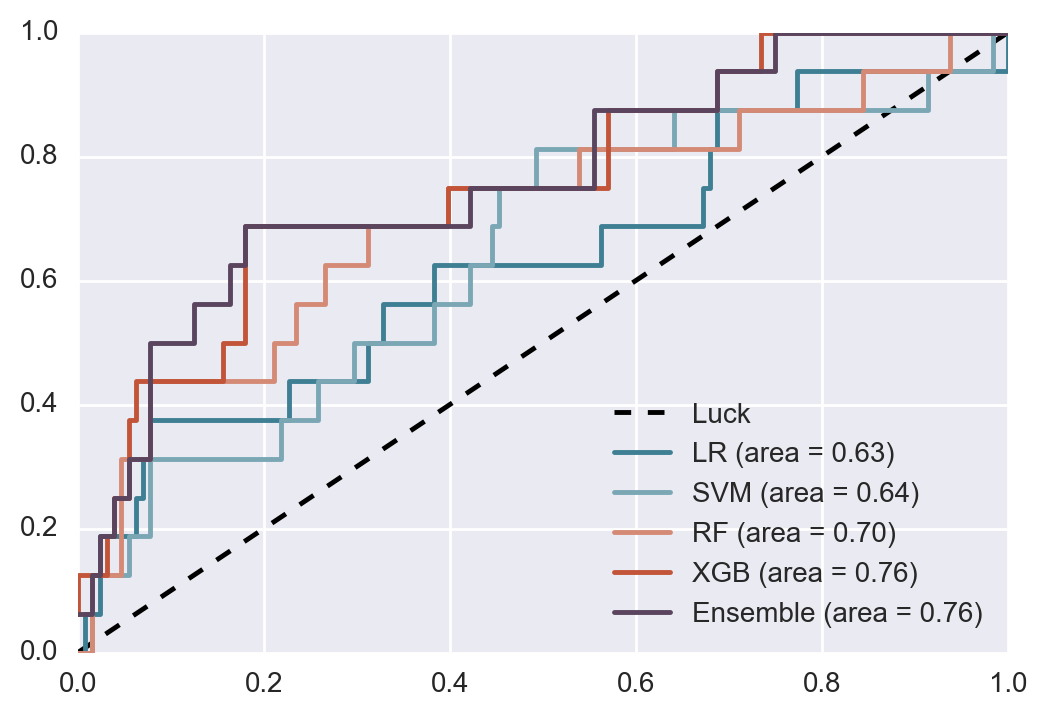

In [24]:
colors = ['#3f7f93', '#7ba7b5', '#d58a76', '#c25539', '#5a445e']

fpr_lr, tpr_lr, _ = roc_curve(Y, cross_val_predict(clf_lr, X, Y, cv=5, method='predict_proba')[:,1])
lr_auc = auc(fpr_lr, tpr_lr)
fpr_svm, tpr_svm, _ = roc_curve(Y, cross_val_predict(clf_svm, X, Y, cv=5, method='predict_proba')[:,1])
svm_auc = auc(fpr_svm, tpr_svm)
fpr_rf, tpr_rf, _ = roc_curve(Y, cross_val_predict(clf_rf, X, Y, cv=5, method='predict_proba')[:,1])
rf_auc = auc(fpr_rf, tpr_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(Y, cross_val_predict(clf_xgb, X, Y, cv=5, method='predict_proba')[:,1])
xgb_auc = auc(fpr_xgb, tpr_xgb)
fpr_en, tpr_en, _ = roc_curve(Y, cross_val_predict(eclf1, X, Y, cv=5, method='predict_proba')[:,1])
en_auc = auc(fpr_en, tpr_en)

plt.plot([0, 1], [0, 1], linestyle='--',color='k', label='Luck')
plt.plot(fpr_lr, tpr_lr, color=colors[0],   label='LR (area = %0.2f)' % (lr_auc))
plt.plot(fpr_svm, tpr_svm, color=colors[1], label='SVM (area = %0.2f)' % (svm_auc))
plt.plot(fpr_rf, tpr_rf, color=colors[2],   label='RF (area = %0.2f)' % (rf_auc))
plt.plot(fpr_xgb, tpr_xgb, color=colors[3], label='XGB (area = %0.2f)' % (xgb_auc))
plt.plot(fpr_en, tpr_en, color=colors[4],   label='Ensemble (area = %0.2f)' % (en_auc))
plt.legend(loc="lower right")
plt.savefig('sd_48.pdf')

In [24]:
X.columns[indices]

Index(['sd2_map', 'sd2_abg_o2', 'sd2_egfr_60', 'total_charlson',
       'hospadmin_egfr60', 'sd2_urea', 'hospadmin_alb', 'sd2_rr',
       'med_history3_y_n', 'hospadmin_alp'],
      dtype='object')

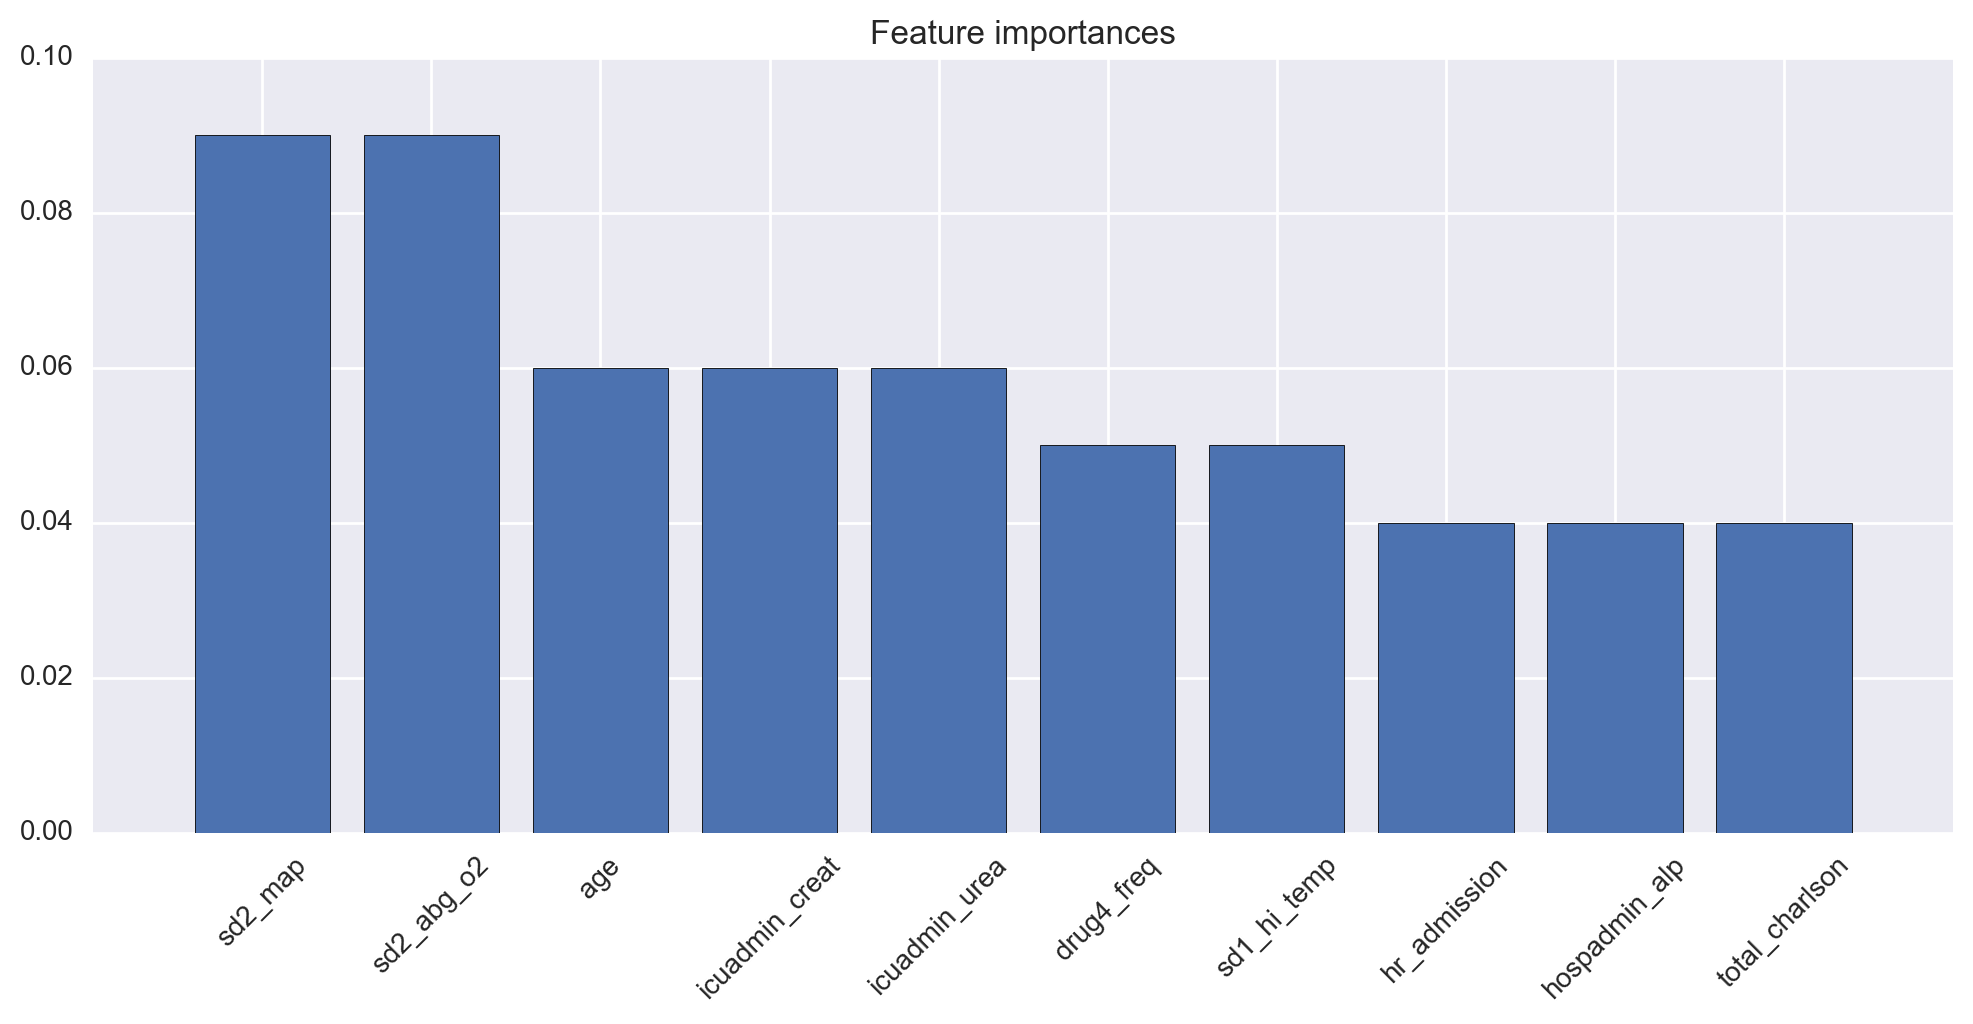

In [69]:
importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1][:10]
std = np.std([classifier.feature_importances_ for tree in classifier.estimators_],
             axis=0)

plt.figure(figsize=(12,5))
plt.title("Feature importances")
plt.bar(range(10), importances[indices],
       yerr=std[indices], align="center")
plt.xticks(range(10), X.columns[indices], rotation=45)
plt.xlim([-1, 10])
plt.show()

# Elastic Net

In [25]:
model_EN = ElasticNetCV(copy_X=True,
                        cv=5, 
                        eps=0.001, 
                        fit_intercept=False,
                        l1_ratio=0.5, 
                        max_iter=1000, 
                        n_alphas=100, 
                        n_jobs=1,
                        normalize=False, 
                        positive=False, 
                        precompute='auto',
                        random_state=None, 
                        selection='cyclic', 
                        tol=0.0001, 
                        verbose=0)

model_EN.fit(X, Y)

//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=False,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [26]:
coef_EN = pd.Series(model_EN.coef_, index = X.columns)
print("Elastic Net picked " + str(sum(coef_EN!=0)) + " variables and eliminated the other " +\
      str(sum(coef_EN==0)) + " variables")

Elastic Net picked 10 variables and eliminated the other 393 variables


In [27]:
cols = coef_EN[coef_EN!=0].index
X    = X[cols]

In [28]:
# imp_coef_EN = coef_EN[coef_EN!=0].sort_values()

# plt.rcParams['figure.figsize'] = (8.0, 6.0)
# imp_coef_EN.plot(kind = "barh")
# plt.title("Features selected by Elastic Net")
# plt.savefig('en_sd_48.pdf')

In [56]:
# SVM
NUM_TRIALS = 10

C_range = np.logspace(-5, 15, 11, base=2.0)
gamma_range = np.logspace(-15, 3, 10, base=2.0) # amendable

p_grid = dict(gamma=gamma_range, C=C_range)

svr = svm.SVC(kernel="rbf",
              class_weight='balanced',
              probability=True)
# svr = svm.SVC(kernel="linear")

non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

for i in range(NUM_TRIALS):

    inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svr, param_grid=p_grid, cv=inner_cv)
    clf.fit(X, Y)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X, y=Y, cv=outer_cv)
    nested_scores[i] = nested_score.mean()
    print('Iter', i+1,'/10 finished')

score_difference = non_nested_scores - nested_scores

print("Average difference of {0:6f} with std. dev. of {1:6f}."
      .format(score_difference.mean(), score_difference.std()))

print("The best parameters are %s with a score of %0.2f"
       % (clf.best_params_, clf.best_score_))

Iter 1 /10 finished
Iter 2 /10 finished
Iter 3 /10 finished
Iter 4 /10 finished
Iter 5 /10 finished
Iter 6 /10 finished
Iter 7 /10 finished
Iter 8 /10 finished
Iter 9 /10 finished
Iter 10 /10 finished
Average difference of 0.025027 with std. dev. of 0.013044.
The best parameters are {'gamma': 8.0, 'C': 2.0} with a score of 0.87


In [91]:
# Random Forest
p_grid = {"max_depth": [2, 3, 5],
          "min_samples_split": [2, 5],
          "min_samples_leaf": [10, 20, 50, 100],
          "criterion": ["gini", "entropy"]}

rf = RandomForestClassifier(class_weight='balanced',
                            bootstrap=False,
                            n_estimators=300,
                            max_features='auto')

inner_cv = KFold(n_splits=5, shuffle=True)
clf = GridSearchCV(estimator=rf, param_grid=p_grid, cv=inner_cv)
clf.fit(X, Y)

print("The best parameters are %s with a score of %0.2f"
       % (clf.best_params_, clf.best_score_))

The best parameters are {'min_samples_split': 2, 'max_depth': 5, 'criterion': 'gini', 'min_samples_leaf': 10} with a score of 0.80


In [160]:
# XGBoost
p_grid = {"learning_rate": [0.01, 0.05, 0.1, 0.2],
          "max_depth": [3],
          "min_child_weight": [1, 2, 3, 5],
          "gamma": [0.0, 0.01, 0.1, 1],
          "subsample": [0.5, 0.7, 1.0],
          "colsample_bytree": [0.5, 0.7, 1]}

clf_xgb = XGBClassifier(scale_pos_weight=8, 
                        n_estimators=100)

inner_cv = KFold(n_splits=5, shuffle=True)
clf = GridSearchCV(estimator=clf_xgb, param_grid=p_grid, cv=inner_cv)
clf.fit(X, Y)

print("The best parameters are %s with a score of %0.2f"
       % (clf.best_params_, clf.best_score_))

The best parameters are {'colsample_bytree': 0.5, 'min_child_weight': 1, 'learning_rate': 0.1, 'gamma': 0.0, 'max_depth': 3, 'subsample': 0.7} with a score of 0.88


In [29]:
clf_svm = svm.SVC(class_weight='balanced',
                  kernel='rbf',
                  C=2,
                  gamma=0.0078125,
                  probability=True)

In [90]:
y_pred = cross_val_predict(clf_svm, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/144)

             precision    recall  f1-score   support

        0.0       0.95      0.75      0.84       128
        1.0       0.26      0.69      0.37        16

avg / total       0.87      0.74      0.79       144

0.71875
0.743055555556


In [30]:
clf_rf = RandomForestClassifier(bootstrap=False, 
                                min_samples_leaf=2, 
                                criterion='gini', 
                                min_samples_split=2, 
                                max_depth=5, 
                                n_estimators=500,
                                max_features='auto')

In [141]:
y_pred = cross_val_predict(clf_rf, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/144)

             precision    recall  f1-score   support

        0.0       0.91      0.98      0.94       128
        1.0       0.57      0.25      0.35        16

avg / total       0.87      0.90      0.88       144

0.61328125
0.895833333333


In [31]:
clf_lr = LogisticRegression(penalty='l2', 
                            dual=True, 
                            C=10,
                            tol=0.0001,
                            fit_intercept=False,
                            intercept_scaling=1, 
                            random_state=None, 
                            solver='liblinear', 
                            max_iter=100, 
                            multi_class='ovr', 
                            verbose=0, 
                            warm_start=False, 
                            n_jobs=1)

In [159]:
y_pred = cross_val_predict(clf_lr, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/144)

             precision    recall  f1-score   support

        0.0       0.89      0.93      0.91       128
        1.0       0.18      0.12      0.15        16

avg / total       0.82      0.84      0.83       144

0.52734375
0.840277777778


In [32]:
clf_xgb = XGBClassifier(learning_rate=0.1,
                           subsample=0.7,
                           n_estimators=200,
                           min_child_weight=1,
                           scale_pos_weight=8,
                           reg_alpha=10,
                           reg_lambda=1,
                           max_depth=3,
                           gamma=0.0,
                           colsample_bytree=0.5)

In [207]:
y_pred = cross_val_predict(clf_xgb, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/144)

             precision    recall  f1-score   support

        0.0       0.96      0.82      0.89       128
        1.0       0.34      0.75      0.47        16

avg / total       0.89      0.81      0.84       144

0.78515625
0.8125


In [33]:
eclf1 = VotingClassifier(estimators=[('xgb', clf_xgb), 
                                     ('lr',  clf_lr),
                                     ('rf', clf_rf),
                                     ('svm', clf_svm)],
                         voting='soft',
                         weights=[20,1,3,1])

In [251]:
y_pred = cross_val_predict(eclf1, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/144)

             precision    recall  f1-score   support

        0.0       0.96      0.87      0.91       128
        1.0       0.39      0.69      0.50        16

avg / total       0.89      0.85      0.86       144

0.77734375
0.847222222222


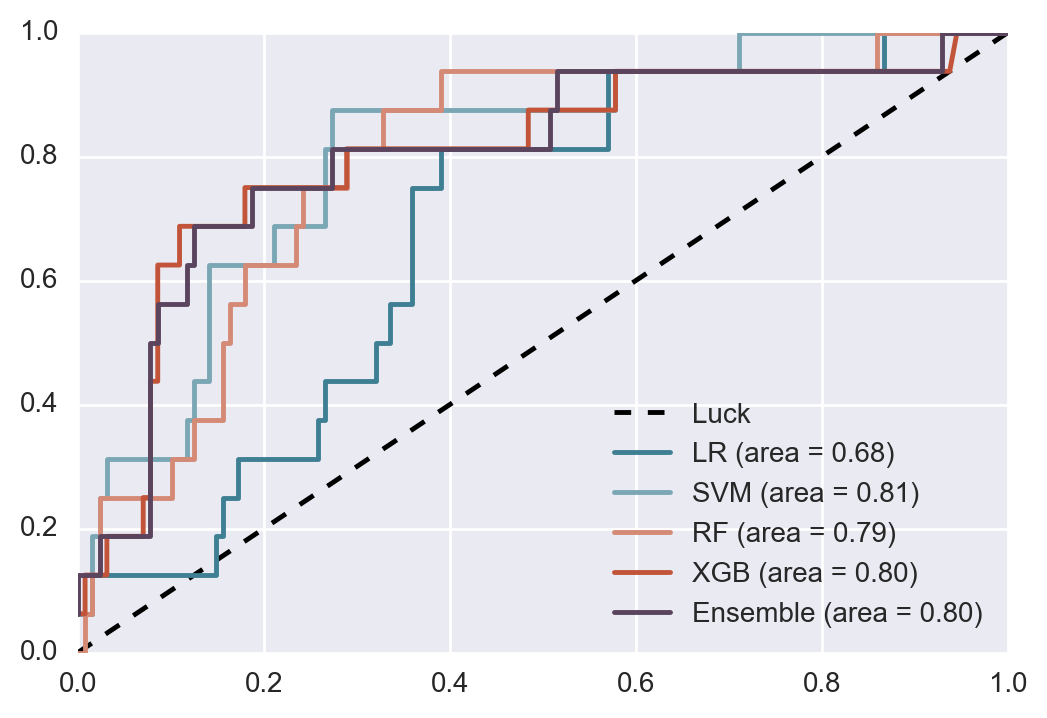

In [34]:
colors = ['#3f7f93', '#7ba7b5', '#d58a76', '#c25539', '#5a445e']

fpr_lr, tpr_lr, _ = roc_curve(Y, cross_val_predict(clf_lr, X, Y, cv=5, method='predict_proba')[:,1])
lr_auc = auc(fpr_lr, tpr_lr)
fpr_svm, tpr_svm, _ = roc_curve(Y, cross_val_predict(clf_svm, X, Y, cv=5, method='predict_proba')[:,1])
svm_auc = auc(fpr_svm, tpr_svm)
fpr_rf, tpr_rf, _ = roc_curve(Y, cross_val_predict(clf_rf, X, Y, cv=5, method='predict_proba')[:,1])
rf_auc = auc(fpr_rf, tpr_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(Y, cross_val_predict(clf_xgb, X, Y, cv=5, method='predict_proba')[:,1])
xgb_auc = auc(fpr_xgb, tpr_xgb)
fpr_en, tpr_en, _ = roc_curve(Y, cross_val_predict(eclf1, X, Y, cv=5, method='predict_proba')[:,1])
en_auc = auc(fpr_en, tpr_en)

plt.plot([0, 1], [0, 1], linestyle='--',color='k', label='Luck')
plt.plot(fpr_lr, tpr_lr, color=colors[0],   label='LR (area = %0.2f)' % (lr_auc))
plt.plot(fpr_svm, tpr_svm, color=colors[1], label='SVM (area = %0.2f)' % (svm_auc))
plt.plot(fpr_rf, tpr_rf, color=colors[2],   label='RF (area = %0.2f)' % (rf_auc))
plt.plot(fpr_xgb, tpr_xgb, color=colors[3], label='XGB (area = %0.2f)' % (xgb_auc))
plt.plot(fpr_en, tpr_en, color=colors[4],   label='Ensemble (area = %0.2f)' % (en_auc))

plt.legend(loc="lower right")
plt.savefig('sd_48_fs.pdf')

//anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


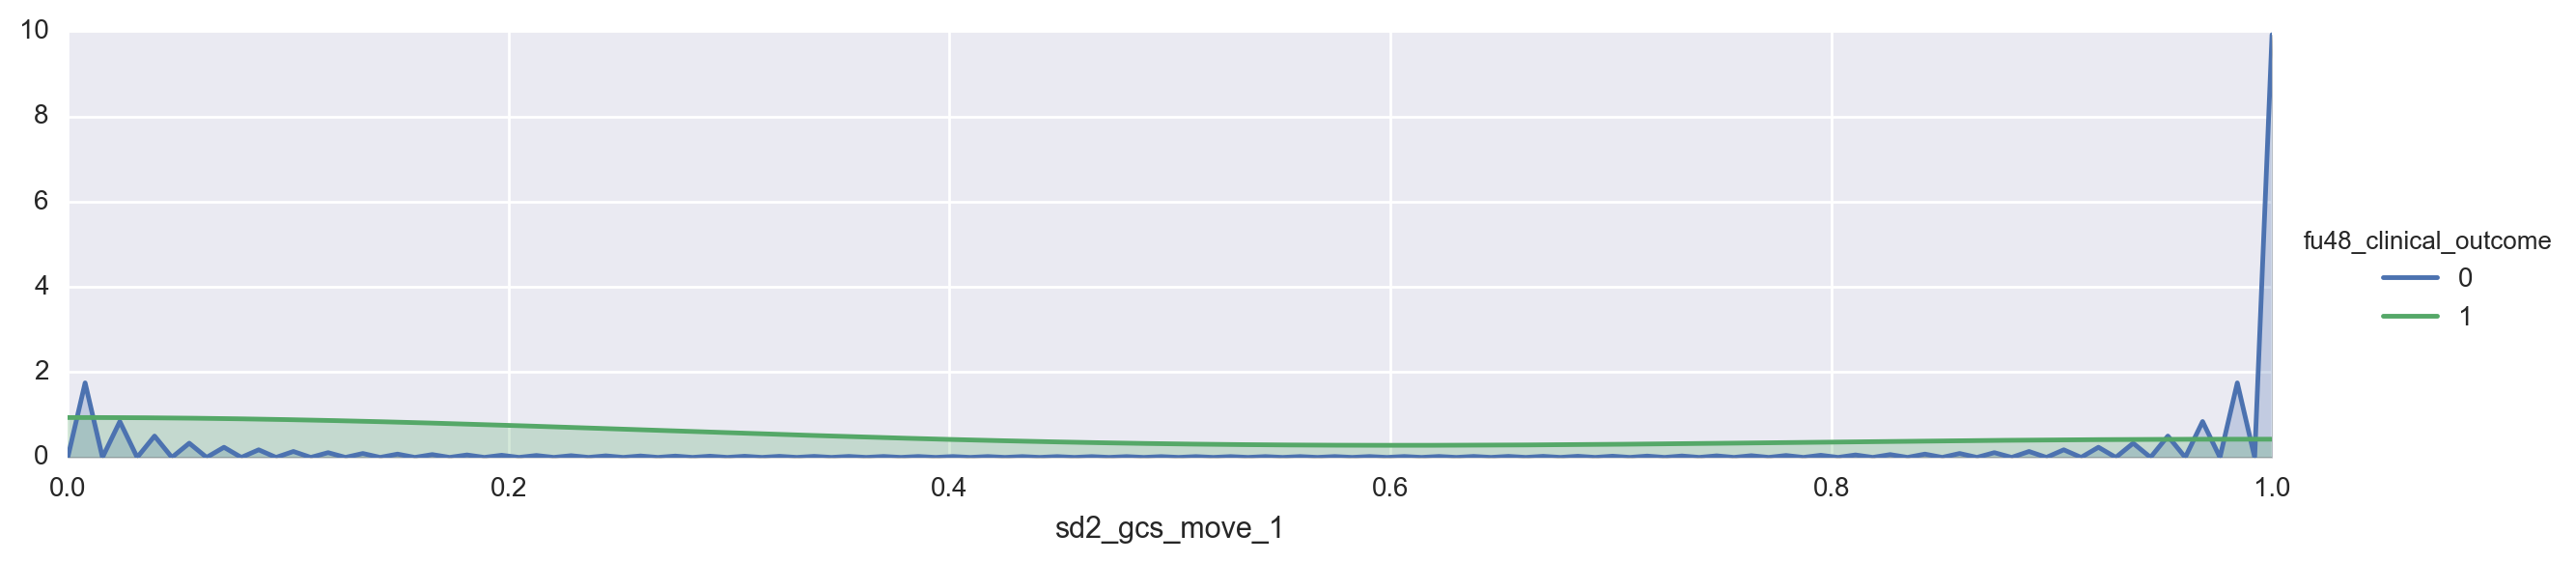

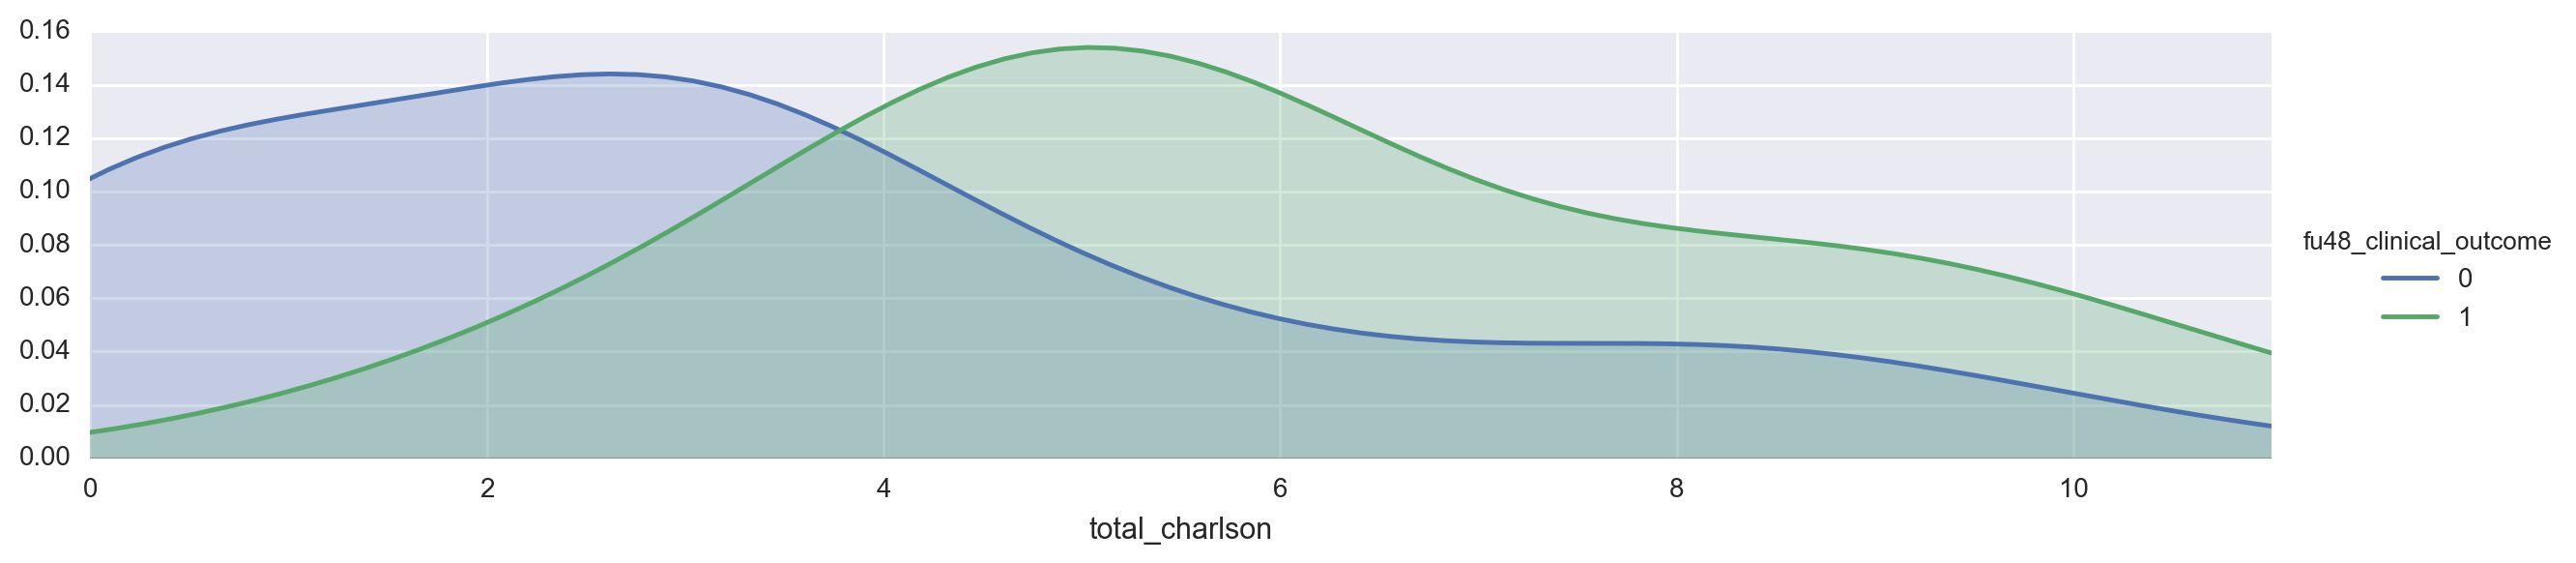

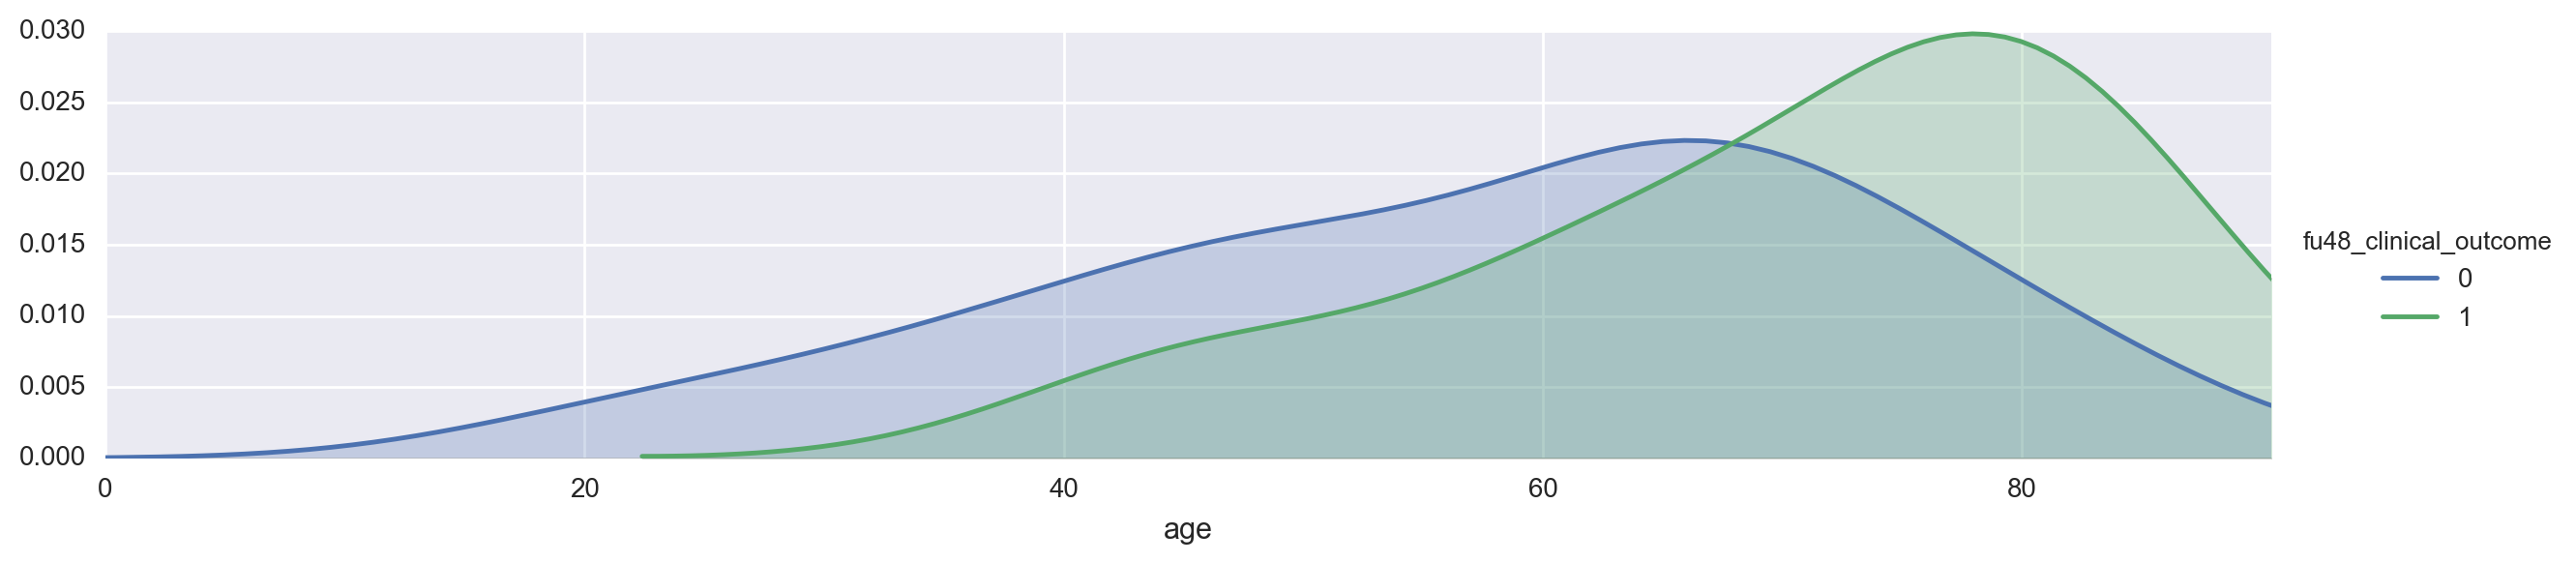

In [73]:
ax1 = sns.FacetGrid(df_fu_48, hue='fu48_clinical_outcome',aspect=4)
ax1.map(sns.kdeplot,'sd2_gcs_move_1',shade= True)
ax1.set(xlim=(0, df_fu_48['sd2_gcs_move_1'].max()))
ax1.add_legend()
plt.savefig('en_feat_sd_48_1.pdf')

ax2 = sns.FacetGrid(df_fu_48, hue='fu48_clinical_outcome',aspect=4)
ax2.map(sns.kdeplot,'total_charlson',shade= True)
ax2.set(xlim=(0, df_fu_48['total_charlson'].max()))
ax2.add_legend()
plt.savefig('en_feat_sd_48_2.pdf')

ax3 = sns.FacetGrid(df_fu_48, hue='fu48_clinical_outcome',aspect=4)
ax3.map(sns.kdeplot,'age',shade= True)
ax3.set(xlim=(0, df_fu_48['age'].max()))
ax3.add_legend()
plt.savefig('en_feat_sd_48_3.pdf')

# Survived/deceased 7 day follow up

In [35]:
df_fu_7 = df.iloc[:,849:991]
df_fu_7 = df_fu_7.drop(['fu7_los'], axis=1)

df_fu_7 = pd.concat([df_fu_48,
                     df_fu_7],axis=1)

drop_dict = ['fu48_cause_of_death',
             'fu48_cause_of_death_other',
             'fu48_abx_change_other',
             'abx_fu48_dose',
             'abx_fu48_freq',
             'abx_fu48_duration',
             'abx2_fu48_yn',
             'abx2_fu48_dose',
             'abx2_fu48_freq',
             'abx2_fu48_duration',
             'abx3_fu48_yn',
             'abx3_fu48_dose',
             'abx3_fu48_freq',
             'abx3_fu48_duration',
             'abx4_fu48_yn',
             'fu48_egfr']

for column in drop_dict:
    df_fu_7 = df_fu_7.drop([column], axis=1)

In [36]:
df_fu_7 = df_fu_7.select_dtypes(exclude=['object'])

for column in df_fu_7:
    if  df_fu_7[column].isnull().sum()/len(df_fu_7)>0.5:
        df_fu_7 = df_fu_7.drop([column], axis=1)

In [37]:
df_fu_7['fu7_clinical_outcome'] = df_fu_7['fu7_clinical_outcome'].replace(1,0)
df_fu_7['fu7_clinical_outcome'] = df_fu_7['fu7_clinical_outcome'].replace(2,0)
df_fu_7['fu7_clinical_outcome'] = df_fu_7['fu7_clinical_outcome'].replace(3,1)

df_fu_7 = df_fu_7.drop(['fu48_clinical_outcome'],axis=1)

In [38]:
df_fu_7 = pd.concat([df_fu_7,
                     df.fu48_clinical_outcome],axis=1)

df_fu_7 = df_fu_7.loc[df_fu_7['fu48_clinical_outcome'] != 4]

cat_dict = ['abx_fu48',
            'abx2_fu48',
            'abx3_fu48',
            'abx4_fu48',
            'fu48_vent',
            'fu48_gcs_eyes',
            'fu48_gcs_voice',
            'fu48_gcs_move',
            'fu48_abg_source',
            'hour_48_follow_up_complete']

for item in cat_dict:
    df_fu_7 = pd.concat([df_fu_7, onehot_column(df_fu_7, item)],axis=1)
    df_fu_7 = df_fu_7.drop([item],axis=1)

In [39]:
df_nnm = NuclearNormMinimization().complete(df_fu_7)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 1008200, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
Variables n = 508857, constraints m = 634553
Cones:	primal zero / dual free vars: 254119
	linear vars: 188544
	sd vars: 191890, sd blks: 1
Setup time: 9.01e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf       nan      -inf       inf       inf  5.37e-01 
   100| 6.20e-03  3.68e-03  7.93e-04  6.63e+04  6.64e+04  9.76e-12  4.88e+01 
   200| 1.99e-03  7.27e-04  2.89e-04  6.64e+04  6.64e+04  3.

In [40]:
df_nnm = pd.DataFrame(df_nnm, columns=df_fu_7.columns, index=df_fu_7.index)

bmi = df_nnm['weight']/((df_nnm['height']/100)**2)
bmi = bmi.to_frame(name='bmi')
df_nnm = pd.concat([df_nnm,
                    bmi], axis=1)

np.any(np.isnan(df_nnm))

False

In [41]:
X = df_nnm.drop(['fu7_clinical_outcome'], axis=1)
Y = df_nnm['fu7_clinical_outcome']

x = X.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X = pd.DataFrame(x_scaled, columns=X.columns)

In [160]:
# x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size = .2)
# x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

In [264]:
# clf_rf = RandomForestClassifier(n_estimators=300,
#                                 bootstrap=True,
#                                 class_weight='balanced',
#                                 max_features='auto',
#                                 random_state=None)
# clf_rf.fit(x_train_res, y_train_res)

In [265]:
# print(classification_report(y_val, clf_rf.predict(x_val)))

In [42]:
clf_lr = LogisticRegression(penalty='l2', 
                            dual=False, 
                            C=0.0001,
                            tol=0.0001,
                            fit_intercept=True,
                            intercept_scaling=1, 
                            random_state=None, 
                            solver='liblinear', 
                            max_iter=100, 
                            multi_class='ovr', 
                            verbose=0, 
                            warm_start=False, 
                            n_jobs=1)

In [326]:
y_pred = cross_val_predict(clf_lr, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/128)

             precision    recall  f1-score   support

        0.0       0.95      1.00      0.97       121
        1.0       0.00      0.00      0.00         7

avg / total       0.89      0.95      0.92       128

0.5
0.9453125


//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [43]:
clf_rf = RandomForestClassifier(bootstrap=False, 
                                min_samples_leaf=50, 
                                criterion='gini', 
                                min_samples_split=2, 
                                max_depth=3, 
                                n_estimators=300,
                                max_features='auto',
                                class_weight='balanced')

In [398]:
y_pred = cross_val_predict(clf_rf, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/128)

             precision    recall  f1-score   support

        0.0       0.96      0.88      0.92       121
        1.0       0.17      0.43      0.24         7

avg / total       0.92      0.85      0.88       128

0.652302243211
0.8515625


In [44]:
clf_svm = svm.SVC(class_weight='balanced',
                  kernel='rbf',
                  C=0.084118762039522274,
                  gamma=0.0625,
                  probability=True)

In [441]:
y_pred = cross_val_predict(clf_svm, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/128)

             precision    recall  f1-score   support

        0.0       0.92      0.20      0.33       121
        1.0       0.05      0.71      0.09         7

avg / total       0.88      0.23      0.31       128

0.456316410862
0.2265625


In [45]:
clf_xgb = XGBClassifier(learning_rate=0.01,
                        subsample=0.5,
                        n_estimators=5000,
                        min_child_weight=2,
                        scale_pos_weight=17.3,
                        reg_alpha=20,
                        reg_lambda=1,
                        max_depth=3,
                        colsample_bytree=0.5)

In [457]:
y_pred = cross_val_predict(clf_xgb, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/128)

             precision    recall  f1-score   support

        0.0       0.97      0.89      0.93       121
        1.0       0.24      0.57      0.33         7

avg / total       0.93      0.88      0.90       128

0.73199527745
0.875


In [46]:
eclf2 = VotingClassifier(estimators=[('xgb', clf_xgb), 
                                     ('rf', clf_rf),
                                     ('svm', clf_svm)],
                         voting='soft',
                         weights=[20,1,5])

In [43]:
y_pred = cross_val_predict(eclf2, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/128)

             precision    recall  f1-score   support

        0.0       0.95      0.98      0.97       121
        1.0       0.33      0.14      0.20         7

avg / total       0.92      0.94      0.93       128

0.563164108619
0.9375


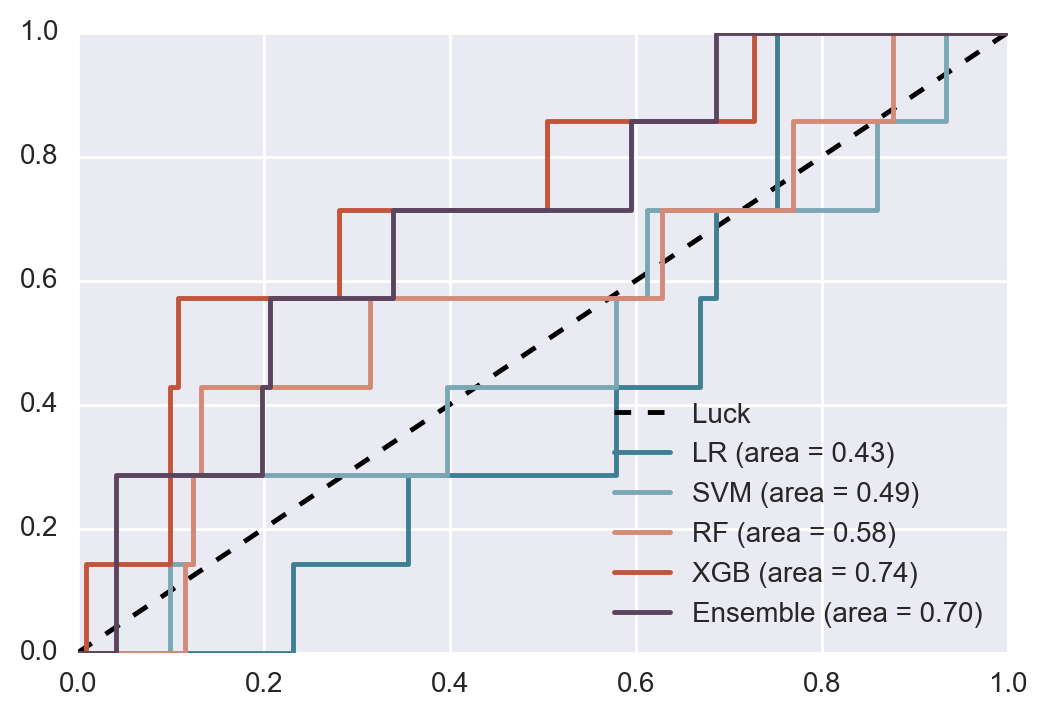

In [50]:
colors = ['#3f7f93', '#7ba7b5', '#d58a76', '#c25539', '#5a445e']

fpr_lr, tpr_lr, _ = roc_curve(Y, cross_val_predict(clf_lr, X, Y, cv=5, method='predict_proba')[:,1])
lr_auc = auc(fpr_lr, tpr_lr)
fpr_svm, tpr_svm, _ = roc_curve(Y, cross_val_predict(clf_svm, X, Y, cv=5, method='predict_proba')[:,1])
svm_auc = auc(fpr_svm, tpr_svm)
fpr_rf, tpr_rf, _ = roc_curve(Y, cross_val_predict(clf_rf, X, Y, cv=5, method='predict_proba')[:,1])
rf_auc = auc(fpr_rf, tpr_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(Y, cross_val_predict(clf_xgb, X, Y, cv=5, method='predict_proba')[:,1])
xgb_auc = auc(fpr_xgb, tpr_xgb)
fpr_en, tpr_en, _ = roc_curve(Y, cross_val_predict(eclf1, X, Y, cv=5, method='predict_proba')[:,1])
en_auc = auc(fpr_en, tpr_en)

plt.plot([0, 1], [0, 1], linestyle='--',color='k', label='Luck')
plt.plot(fpr_lr, tpr_lr, color=colors[0],   label='LR (area = %0.2f)' % (lr_auc))
plt.plot(fpr_svm, tpr_svm, color=colors[1], label='SVM (area = %0.2f)' % (svm_auc))
plt.plot(fpr_rf, tpr_rf, color=colors[2],   label='RF (area = %0.2f)' % (rf_auc))
plt.plot(fpr_xgb, tpr_xgb, color=colors[3], label='XGB (area = %0.2f)' % (xgb_auc))
plt.plot(fpr_en, tpr_en, color=colors[4],   label='Ensemble (area = %0.2f)' % (en_auc))

plt.legend(loc="lower right")
plt.savefig('sd_7.pdf')

# Elastic Net

In [51]:
model_EN = ElasticNetCV(copy_X=True,
                        cv=5, 
                        eps=0.001, 
                        fit_intercept=False,
                        l1_ratio=0.5, 
                        max_iter=1000, 
                        n_alphas=100, 
                        n_jobs=1,
                        normalize=False, 
                        positive=False, 
                        precompute='auto',
                        random_state=None, 
                        selection='cyclic', 
                        tol=0.0001, 
                        verbose=0)

model_EN.fit(X, Y)

//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=False,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [52]:
coef_EN = pd.Series(model_EN.coef_, index = X.columns)
print("Elastic Net picked " + str(sum(coef_EN!=0)) + " variables and eliminated the other " +\
      str(sum(coef_EN==0)) + " variables")

Elastic Net picked 3 variables and eliminated the other 488 variables


In [53]:
cols = coef_EN[coef_EN!=0].index
X    = X[cols]

In [262]:
# SVM
NUM_TRIALS = 10

C_range = np.logspace(-5, 15, 11, base=2.0)
gamma_range = np.logspace(-15, 3, 10, base=2.0) # amendable

p_grid = dict(gamma=gamma_range, C=C_range)

svr = svm.SVC(kernel="rbf",
              class_weight='balanced')
# svr = svm.SVC(kernel="linear")

non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svr, param_grid=p_grid, cv=inner_cv)
    clf.fit(X, Y)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X, y=Y, cv=outer_cv)
    nested_scores[i] = nested_score.mean()
    print('Iter', i+1,'/10 finished')

score_difference = non_nested_scores - nested_scores

print("Average difference of {0:6f} with std. dev. of {1:6f}."
      .format(score_difference.mean(), score_difference.std()))

print("The best parameters are %s with a score of %0.2f"
       % (clf.best_params_, clf.best_score_))

Iter 1 /10 finished
Iter 2 /10 finished
Iter 3 /10 finished
Iter 4 /10 finished
Iter 5 /10 finished
Iter 6 /10 finished
Iter 7 /10 finished
Iter 8 /10 finished
Iter 9 /10 finished
Iter 10 /10 finished
Average difference of 0.183866 with std. dev. of 0.152873.
The best parameters are {'gamma': 2.0, 'C': 0.03125} with a score of 0.70


In [287]:
# Random Forest
p_grid = {"max_depth": [2, 3, 5],
          "min_samples_split": [2, 5],
          "min_samples_leaf": [10, 20, 50, 100],
          "criterion": ["gini", "entropy"]}

rf = RandomForestClassifier(class_weight='balanced',
                            bootstrap=False,
                            n_estimators=300,
                            max_features='auto')

inner_cv = KFold(n_splits=5, shuffle=True)
clf = GridSearchCV(estimator=rf, param_grid=p_grid, cv=inner_cv)
clf.fit(X, Y)

print("The best parameters are %s with a score of %0.2f"
       % (clf.best_params_, clf.best_score_))

The best parameters are {'min_samples_split': 2, 'max_depth': 2, 'criterion': 'gini', 'min_samples_leaf': 100} with a score of 0.95


In [368]:
# XGBoost
p_grid = {"learning_rate": [0.01, 0.05, 0.1, 0.2],
          "max_depth": [3],
          "min_child_weight": [1, 2, 3, 5],
          "gamma": [0.0, 0.01, 0.1, 1],
          "subsample": [0.5, 0.7, 1.0],
          "colsample_bytree": [0.5, 0.7, 1]}

clf_xgb = XGBClassifier(scale_pos_weight=8, 
                        n_estimators=100)

inner_cv = KFold(n_splits=5, shuffle=True)
clf = GridSearchCV(estimator=clf_xgb, param_grid=p_grid, cv=inner_cv)
clf.fit(X, Y)

print("The best parameters are %s with a score of %0.2f"
       % (clf.best_params_, clf.best_score_))

The best parameters are {'colsample_bytree': 0.5, 'min_child_weight': 3, 'learning_rate': 0.01, 'gamma': 0.0, 'max_depth': 3, 'subsample': 0.5} with a score of 0.95


In [54]:
clf_svm = svm.SVC(class_weight='balanced',
                  kernel='rbf',
                  C=0.03125,
                  gamma=2.0,
                  probability=True)

In [286]:
y_pred = cross_val_predict(clf_svm, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/128)

             precision    recall  f1-score   support

        0.0       1.00      0.66      0.80       121
        1.0       0.15      1.00      0.25         7

avg / total       0.95      0.68      0.77       128

0.830578512397
0.6796875


In [55]:
clf_rf = RandomForestClassifier(bootstrap=False, 
                                min_samples_leaf=20, 
                                criterion='gini', 
                                min_samples_split=2, 
                                max_depth=2, 
                                n_estimators=300,
                                max_features='auto',
                                class_weight='balanced')

In [315]:
y_pred = cross_val_predict(clf_rf, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/128)

             precision    recall  f1-score   support

        0.0       1.00      0.68      0.81       121
        1.0       0.15      1.00      0.26         7

avg / total       0.95      0.70      0.78       128

0.838842975207
0.6953125


In [56]:
clf_lr = LogisticRegression(penalty='l2', 
                            dual=True, 
                            C=1000000,
                            tol=0.0001,
                            fit_intercept=True,
                            intercept_scaling=1, 
                            random_state=None, 
                            solver='liblinear', 
                            max_iter=100, 
                            multi_class='ovr', 
                            verbose=0, 
                            warm_start=False, 
                            n_jobs=1)

In [367]:
y_pred = cross_val_predict(clf_lr, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/128)

             precision    recall  f1-score   support

        0.0       0.96      0.86      0.91       121
        1.0       0.15      0.43      0.22         7

avg / total       0.92      0.84      0.87       128

0.644037780401
0.8359375


In [64]:
clf_xgb = XGBClassifier(learning_rate=0.01,
                        subsample=0.7,
                        n_estimators=100,
                        min_child_weight=3,
                        gamma=0.0,
                        reg_alpha=0,
                        reg_lambda=1,
                        max_depth=3,
                        colsample_bytree=0.7)

In [65]:
y_pred = cross_val_predict(clf_xgb, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/128)

             precision    recall  f1-score   support

        0.0       0.95      1.00      0.97       121
        1.0       0.00      0.00      0.00         7

avg / total       0.89      0.95      0.92       128

0.5
0.9453125


//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [58]:
eclf2 = VotingClassifier(estimators=[('rf', clf_rf), 
                                     ('lr',  clf_lr),
                                     ('svm', clf_svm)],
                         voting='soft',
                         weights=[6,1,1])

In [442]:
y_pred = cross_val_predict(eclf1, X, Y, cv=5)
print(classification_report(Y, y_pred))
print(roc_auc_score(Y, y_pred))
print((y_pred==Y).sum()/128)

             precision    recall  f1-score   support

        0.0       0.97      0.79      0.87       121
        1.0       0.13      0.57      0.22         7

avg / total       0.92      0.77      0.83       128

0.678276269185
0.7734375


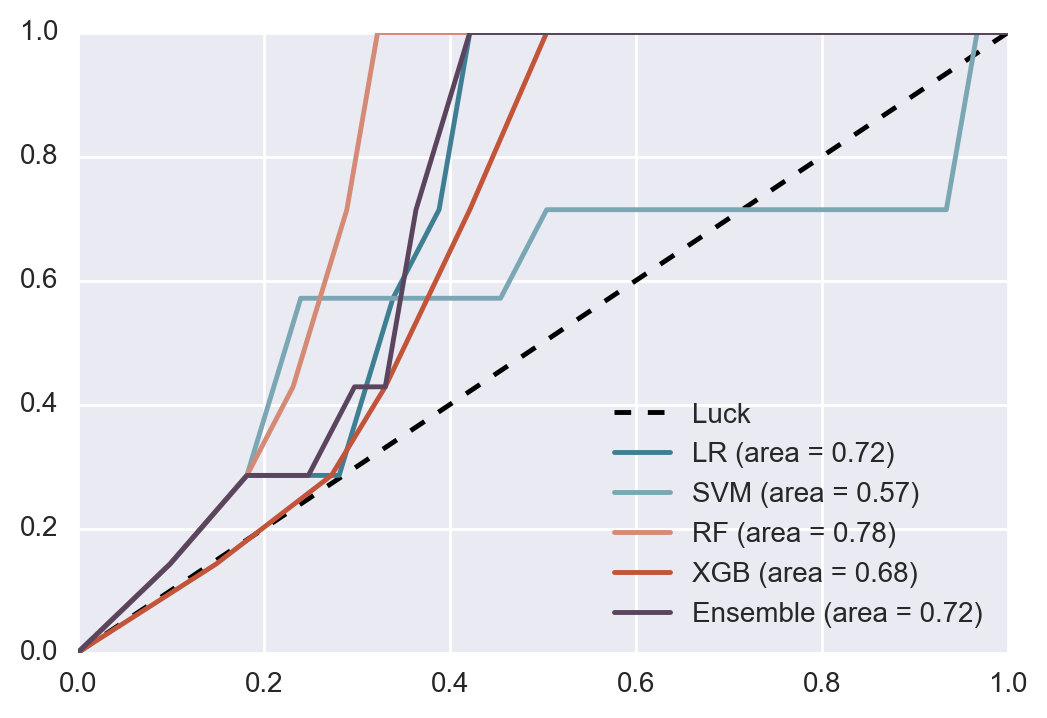

In [67]:
colors = ['#3f7f93', '#7ba7b5', '#d58a76', '#c25539', '#5a445e']

fpr_lr, tpr_lr, _ = roc_curve(Y, cross_val_predict(clf_lr, X, Y, cv=5, method='predict_proba')[:,1])
lr_auc = auc(fpr_lr, tpr_lr)
fpr_svm, tpr_svm, _ = roc_curve(Y, cross_val_predict(clf_svm, X, Y, cv=5, method='predict_proba')[:,1])
svm_auc = auc(fpr_svm, tpr_svm)
fpr_rf, tpr_rf, _ = roc_curve(Y, cross_val_predict(clf_rf, X, Y, cv=5, method='predict_proba')[:,1])
rf_auc = auc(fpr_rf, tpr_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(Y, cross_val_predict(clf_xgb, X, Y, cv=5, method='predict_proba')[:,1])
xgb_auc = auc(fpr_xgb, tpr_xgb)
fpr_en, tpr_en, _ = roc_curve(Y, cross_val_predict(eclf1, X, Y, cv=5, method='predict_proba')[:,1])
en_auc = auc(fpr_en, tpr_en)

plt.plot([0, 1], [0, 1], linestyle='--',color='k', label='Luck')
plt.plot(fpr_lr, tpr_lr, color=colors[0],   label='LR (area = %0.2f)' % (lr_auc))
plt.plot(fpr_svm, tpr_svm, color=colors[1], label='SVM (area = %0.2f)' % (svm_auc))
plt.plot(fpr_rf, tpr_rf, color=colors[2],   label='RF (area = %0.2f)' % (rf_auc))
plt.plot(fpr_xgb, tpr_xgb, color=colors[3], label='XGB (area = %0.2f)' % (xgb_auc))
plt.plot(fpr_en, tpr_en, color=colors[4],   label='Ensemble (area = %0.2f)' % (en_auc))

plt.legend(loc="lower right")
plt.savefig('sd_7_fs.pdf')